# <font style="color:blue">Run Length Encoding for kaggle competition</font>



In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [3]:
import os
import time
import cv2

from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

In [4]:
def rle_encoding(id, tensor, num_classes):

    tensor_flatten = tensor.flatten().numpy()

    out = ""

    for i in range(0, num_classes):
        
        out = out + str(id) + '_' + str(i) + ','

        run_lengths = []
        
        for j in range(len(tensor_flatten)):
            run_lengths.append([])
            dots = np.where(tensor_flatten==i)[0]

            prev = -2
            for b in dots:
                if (b>prev+1): run_lengths[-1].extend((b, 0))
                run_lengths[-1][-1] += 1
                prev = b

            break

        rle = np.array(run_lengths[0]).astype('uint16')

        numElems = len(rle)
        #rint("num Elems: ", numElems)
        for j in range(0, numElems):
            out = out + str(rle[j])

            if j < numElems - 1:
                out = out + ' '

        #for j in rle:
        #    out = out + str(j) + ' '

        out = out + '\n'

    return out

In [5]:
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
print(thisdict)

{'brand': 'Ford', 'model': 'Mustang', 'year': 1964}


Class ID	Class	Mask Color Code (R,G,B)
0	Background	(0, 0, 0)
1	Person	(192, 128, 128)
2	Bike	(0, 128,0 )
3	Car	(128,128,128)
4	Drone	(128, 0,0)
5	Boat	(0, 0, 128)
6	Animal	(192,0,128)
7	Obstacle	(192, 0,0)
8	Construction	(192, 128, 0)
9	Vegetation	(0, 64, 0)
10	Road	(128, 128, 0)
11	Sky	(0, 128, 128)

How we got masking for each of these 3 class: After inference, we resized (using nearest-neighbor interpolation) mask to the original image width and height. In this way, we got the mask.

In [6]:
classes = {

    'Background': {
        'ID': 0,
        'CODE': [0, 0, 0]
    },
    'Person': {
        'ID': 1,
        'CODE': [192, 128, 128]
    },
    'Bike': {
        'ID': 2,
        'CODE': [0, 128, 0]
    },
    'Car': {
        'ID': 3,
        'CODE': [128, 128, 128]
    },
    'Drone': {
        'ID': 4,
        'CODE': [128, 0, 0]
    },
    'Boat': {
        'ID': 5,
        'CODE': [0, 0, 128]
    },
    'Animal': {
        'ID': 6,
        'CODE': [192, 0, 128]
    },
    'Obstacle': {
        'ID': 7,
        'CODE': [192, 0, 0]
    },
    'Construction': {
        'ID': 8,
        'CODE': [192, 128, 0]
    },
    'Vegetation': {
        'ID': 9,
        'CODE': [0, 64, 0]
    },
    'Road': {
        'ID': 10,
        'CODE': [128, 128, 0]
    },
    'Sky': {
        'ID': 11,
        'CODE': [0, 128, 128]
    }
}

print(classes)

{'Background': {'ID': 0, 'CODE': [0, 0, 0]}, 'Person': {'ID': 1, 'CODE': [192, 128, 128]}, 'Bike': {'ID': 2, 'CODE': [0, 128, 0]}, 'Car': {'ID': 3, 'CODE': [128, 128, 128]}, 'Drone': {'ID': 4, 'CODE': [128, 0, 0]}, 'Boat': {'ID': 5, 'CODE': [0, 0, 128]}, 'Animal': {'ID': 6, 'CODE': [192, 0, 128]}, 'Obstacle': {'ID': 7, 'CODE': [192, 0, 0]}, 'Construction': {'ID': 8, 'CODE': [192, 128, 0]}, 'Vegetation': {'ID': 9, 'CODE': [0, 64, 0]}, 'Road': {'ID': 10, 'CODE': [128, 128, 0]}, 'Sky': {'ID': 11, 'CODE': [0, 128, 128]}}


In [7]:
# loop over dict values
for val in classes.values():
    print(val)

{'ID': 0, 'CODE': [0, 0, 0]}
{'ID': 1, 'CODE': [192, 128, 128]}
{'ID': 2, 'CODE': [0, 128, 0]}
{'ID': 3, 'CODE': [128, 128, 128]}
{'ID': 4, 'CODE': [128, 0, 0]}
{'ID': 5, 'CODE': [0, 0, 128]}
{'ID': 6, 'CODE': [192, 0, 128]}
{'ID': 7, 'CODE': [192, 0, 0]}
{'ID': 8, 'CODE': [192, 128, 0]}
{'ID': 9, 'CODE': [0, 64, 0]}
{'ID': 10, 'CODE': [128, 128, 0]}
{'ID': 11, 'CODE': [0, 128, 128]}


In [21]:
def mask2rle(id, tensor, num_classes): 

    mask = tensor.numpy()

    rle = ["" for x in range(num_classes)]

    mask_classes = np.unique(mask)

    for clx in mask_classes:
        mask_clx = (mask == clx).astype(np.uint8)
        pixels = mask_clx[:,:].T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] #+ 1
        runs[1::2] -= runs[::2]
        rle[clx] = ' '.join(str(x) for x in runs)

    #print(rle)
    out = ""
    clIdx = 0
    for cl in rle:
        out = out + str(id) + '_' + str(clIdx) + ','
        clIdx = clIdx + 1

        vals = cl.split(" ")
        #print(vals)

        numElems = len(vals)
        #print(numElems)
        for j in range(0, numElems):
            val = vals[j]

            if not val.isnumeric():
                continue

            out = out + val

            if j < numElems - 1:
               out = out + ' '

        out = out + '\n'

    #print(out)

    return out

In [111]:
def mask2rle_fast(id, tensor, num_classes): 

    mask = tensor.numpy()

    rle = ["{}_{},".format(id, x) for x in range(num_classes)]

    print(rle)

    mask_classes = np.unique(mask)

    for clx in mask_classes:
        # Get the mask for the ccurrent class
        mask_clx = (mask == clx).astype(np.uint8)

        # Flatten the PC
        pixels = mask_clx.T.flatten()

        pixels = np.pad(pixels, ((1, 1), ))

        runs = np.where(pixels[1:] != pixels[:-1])[0]

        runs[1::2] -= runs[::2]

        for x in runs:
            rle[clx] = rle[clx] + str(x) + ' '

    return rle

In [100]:
def mask2rle_pixelwise(id, tensor, num_classes):
   
    mask = tensor.numpy()

    rle = ["{}_{},".format(id, x) for x in range(num_classes)]
    #print(rle)

    mask_classes = np.unique(mask)

    #print("Mask Classes: ", mask_classes)

    for class_idx in mask_classes:
        # Get the mask for the ccurrent class
        mask_class = (mask == class_idx).astype(np.uint8)

        # grab the image dimensions
        h = mask_class.shape[0]
        w = mask_class.shape[1]

        #print("Class {} Width {}, Height {}\n".format(class_idx, w, h))

        pixel_idx = 0
        start_idx = 0
        pixel_count = 0
        first = True
        counting = False

        # loop over the image
        for x in range(0, w):
            for y in range(0, h):
            
                if mask_class[y, x] == 1:

                    pixel_count = pixel_count + 1
                    counting = True
                    
                    if first:
                        start_idx = pixel_idx
                        #print("Start Index Class {}: {}".format(class_idx, start_idx))
                        first = False
                    
                else:
                    if counting:
                        rle[class_idx] = rle[class_idx] + str(start_idx) + ' ' + str(pixel_count) + ' '
                        counting = False
                        pixel_count = 0
                        first = True

                pixel_idx = pixel_idx + 1

                if x == w - 1 and y == h - 1 and counting:
                    rle[class_idx] = rle[class_idx] + str(start_idx) + ' ' + str(pixel_count) + ' '
                    counting = False
                    pixel_count = 0
                    first = True

    return rle

      
    

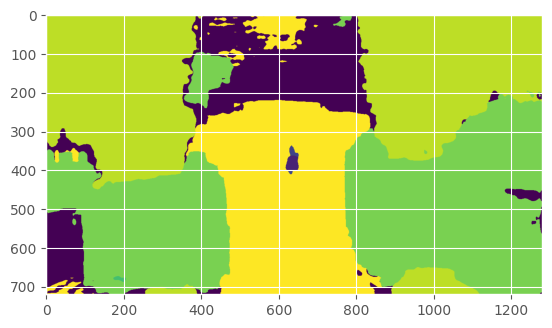

In [10]:
fileName = "C:/Users/adlerd/Downloads/predictedMask.png"
maskImage = cv2.imread(fileName, 0)
plt.imshow(maskImage) 

In [13]:
print("Mask Shape: ", maskImage.shape)
maskTensor = torch.from_numpy(maskImage)
print("Tensor Shape: ", maskTensor.shape)

Mask Shape:  (720, 1280)
Tensor Shape:  torch.Size([720, 1280])


In [114]:
num_classes = 12
imageID = "mask"

#print("Pixel wise")
#pw_rle = mask2rle_pixelwise(imageID, maskTensor, num_classes)

#for rle_idx in pw_rle:
#    print(rle_idx)
#    break

print("Fast")
fast_rle = mask2rle_fast(imageID, maskTensor, num_classes)


for rle_idx in fast_rle:
    print(rle_idx)



#for idx in range(0, len(pw_rle)-1):
#    print(pw_rle[idx] == fast_rle[idx])

#print("Mask1 RLE\n", mask2rle_fast(imageID, maskTensor, num_classes))


#print("Mask1 RLE\n", mask2rle(imageID, maskTensor, num_classes))
#

Fast
['mask_0,', 'mask_1,', 'mask_2,', 'mask_3,', 'mask_4,', 'mask_5,', 'mask_6,', 'mask_7,', 'mask_8,', 'mask_9,', 'mask_10,', 'mask_11,']
mask_0,327 25 509 194 718 2 1047 25 1229 194 1438 2 1768 24 1950 193 2158 2 2490 20 2670 193 2874 4 3211 18 3391 192 3593 5 3932 17 4112 191 4312 6 4653 15 4832 191 5032 6 5374 14 5552 190 5752 6 6097 11 6271 191 6472 6 6819 9 6991 190 7191 7 7539 10 7711 190 7911 7 8260 9 8431 189 8631 7 8981 8 9150 190 9351 6 9702 8 9870 189 10071 6 10422 9 10590 188 10791 6 11142 10 11310 188 11511 6 11862 11 12030 187 12231 6 12582 12 12749 188 12951 6 13302 13 13469 187 13671 6 14021 15 14189 187 14391 6 14741 17 14909 187 15110 7 15460 29 15628 187 15830 7 16180 16 16205 10 16348 187 16549 8 16899 15 17068 186 17269 8 17619 13 17788 186 17987 10 18338 13 18508 185 18705 12 19057 13 19228 185 19424 13 19775 15 19948 185 20143 13 20493 17 20667 185 20861 15 21212 18 21387 185 21580 15 21922 5 21931 19 22107 184 22299 16 22642 30 22827 184 23019 15 23361 33 2354

In [15]:
num_classes = 4

imageid1 ="248462385"

mask1 = torch.tensor([[3, 0, 1, 1],
                      [3, 3, 1, 0],
                      [0, 1, 3, 0]])

print("Mask1\n", mask1)
print("Shape Mask1\n", mask1.shape)

mask_clx = (mask1.numpy() == 0).astype(np.uint8)
print("Mask1 Val 0\n", mask_clx)

pixels = mask_clx[:,:].T.flatten()
print("Pixesl Val 0 Flatten\n", pixels)

pixels = mask_clx.T.flatten()
print("Pixesl Val 0 Flatten\n", pixels)

pixels = np.pad(pixels, ((1, 1), ))
print("Pixesl Pad\n", pixels)

print("Mask1 RLE\n", mask2rle(imageid1, mask1, num_classes))
print("Mask1 RLE\n", mask2rle_fast(imageid1, mask1, num_classes))

#imageid2= "12455519"

#mask2 = torch.tensor([[2, 2, 2, 3],
#        [2, 0, 0, 3],
#        [1, 2, 1, 2],
#        [0, 0, 0, 1]])



#tensor_flatten = tensor.flatten().numpy()
#imageid1 ="248462385"
#print("Mask1\n", mask1)
#print("Shape Mask1\n", mask1.shape)
#print("Mask1 RLE\n", mask2rle(imageid1, mask1, num_classes))

    

Mask1
 tensor([[3, 0, 1, 1],
        [3, 3, 1, 0],
        [0, 1, 3, 0]])
Shape Mask1
 torch.Size([3, 4])
Mask1 Val 0
 [[0 1 0 0]
 [0 0 0 1]
 [1 0 0 1]]
Pixesl Val 0 Flatten
 [0 0 1 1 0 0 0 0 0 0 1 1]
Pixesl Val 0 Flatten
 [0 0 1 1 0 0 0 0 0 0 1 1]
Pixesl Pad
 [0 0 0 1 1 0 0 0 0 0 0 1 1 0]
Mask1 RLE
 ['3 2 11 2', '6 3 10 1', ' ', '1 2 5 1 9 1']
Mask1 RLE
 ['3 2 11 2', '6 3 10 1', ' ', '1 2 5 1 9 1']
